<a href="https://colab.research.google.com/github/PetrGavrilin/VKR_URFU/blob/main/VKR_part7_DenseNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Нейронная сеть</h1>

In [1]:
# Загрузка необходимых библиотек и функций

import sys
sys.path.append('/content')

from vkr_function import my_features_extraction, print_scores, plot_predict, my_test_train_split, my_test_val_train_split

import os

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential #Сеть прямого распространения
#Базовые слои для свёрточных сетей
#from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D,  Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Dense, RNN, LSTM, GRU,  Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam # оптимизатор

try:
  from plot_keras_history import show_history, plot_history
except:
  !pip install plot_keras_history
  from plot_keras_history import show_history, plot_history


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9456 sha256=7665e22151f496d3d50c7c9004d60e0f226bcbd754f3e46ae379f7b2f19912a2
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.51-py3-none-any.whl size=321866 sha256=13cc3fc84da81fe5beadf5638ecd6ab0ab424619eebc67b67139889dd101a8ac
  Stored in directory: /root/.cache/pip/wheels/30/9f/f5/37d037c39ac8b305590d5956f7021c6ca94b63c68be24f6841
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=9d1ff25b5c457a85dffaeac5676e496ace3bf45d5731daa83e367c3bab3b7827
  Stored in directo

In [2]:
# Загрузка данных
Y_ = pd.read_csv('/content/flow_rate.csv')
sig_up = pd.read_csv('/content/sig_up.csv')
sig_dw = pd.read_csv('/content/sig_dw.csv')
borders = pd.read_csv('/content/borders.csv').values.tolist()[0]

In [3]:
X = np.hstack([sig_up, sig_dw])
X.shape

scaler_up = preprocessing.StandardScaler()
X = scaler_up.fit_transform(X)


In [4]:
# Разделение на выборки

Y = np.array(Y_['Et'])
input_dim = X.shape[1]

X_train, y_train, i_train, X_val, y_val, i_val, X_test, y_test, i_test =  my_test_val_train_split(X, Y, borders)

In [5]:
# изменение формата данных
X_train = tf.convert_to_tensor(X_train, np.float32)
X_test = tf.convert_to_tensor(X_test, np.float32)
X_val = tf.convert_to_tensor(X_val, np.float32)
y_train = tf.convert_to_tensor(y_train, np.float32)
y_val = tf.convert_to_tensor(y_val, np.float32)
y_test = tf.convert_to_tensor(y_test, np.float32)

In [76]:
# Рекуррентная нейронная сеть

model = Sequential()
model.add(BatchNormalization(input_shape=(1024, )))
model.add(Dense(256, activation='tanh', name="Dense_1"))
#model.add(Dropout(0.01))
model.add(Dense(128, activation='relu6', name="Dense_2"))
model.add(Dense(1, activation='relu6', name="Dense_3"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 Dense_1 (Dense)             (None, 256)               262400    
                                                                 
 Dense_2 (Dense)             (None, 128)               32896     
                                                                 
 Dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 299521 (1.14 MB)
Trainable params: 297473 (1.13 MB)
Non-trainable params: 2048 (8.00 KB)
_________________________________________________________________


In [78]:
opt = keras.optimizers.Adam(
   learning_rate=0.0001
) # оптимизатор

try:
  model.load_weights('model.h5')
except:
  model.save_weights('model.h5') # сохранение весов

# компиляция модели
model.compile(
    optimizer=opt,
    loss='mean_squared_error',
    metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.R2Score()]
    )

In [8]:
# сброс лучшей модели
try:
    os.remove("/content/Checkpoint_path.keras")
except OSError:
    pass

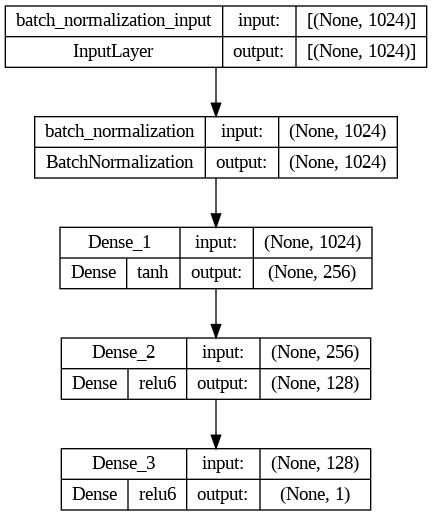

In [9]:
# вывод струтуры модели
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_activations=True,
    )

In [79]:
# класс обратного вызова
callback_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=364,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="Checkpoint_path.keras",
        nonitor="val_loss",
        save_best_only=True,
    )
]

In [11]:
# Обучение модели
history = model.fit(
    X_train, y_train, epochs=512, batch_size=64,
    callbacks=callback_list, validation_data=(X_val, y_val)
    )

Epoch 1/512
40/40 [==============================] - 2s 18ms/step - loss: 1.6218 - root_mean_squared_error: 1.2735 - r2_score: -2.1297 - val_loss: 0.6680 - val_root_mean_squared_error: 0.8173 - val_r2_score: -0.2983
Epoch 2/512
40/40 [==============================] - 1s 13ms/step - loss: 0.2589 - root_mean_squared_error: 0.5088 - r2_score: 0.5004 - val_loss: 0.1040 - val_root_mean_squared_error: 0.3225 - val_r2_score: 0.7978
Epoch 3/512
40/40 [==============================] - 1s 20ms/step - loss: 0.0851 - root_mean_squared_error: 0.2918 - r2_score: 0.8357 - val_loss: 0.0482 - val_root_mean_squared_error: 0.2196 - val_r2_score: 0.9063
Epoch 4/512
40/40 [==============================] - 1s 20ms/step - loss: 0.0565 - root_mean_squared_error: 0.2376 - r2_score: 0.8910 - val_loss: 0.0370 - val_root_mean_squared_error: 0.1923 - val_r2_score: 0.9281
Epoch 5/512
40/40 [==============================] - 1s 23ms/step - loss: 0.0454 - root_mean_squared_error: 0.2130 - r2_score: 0.9124 - val_lo

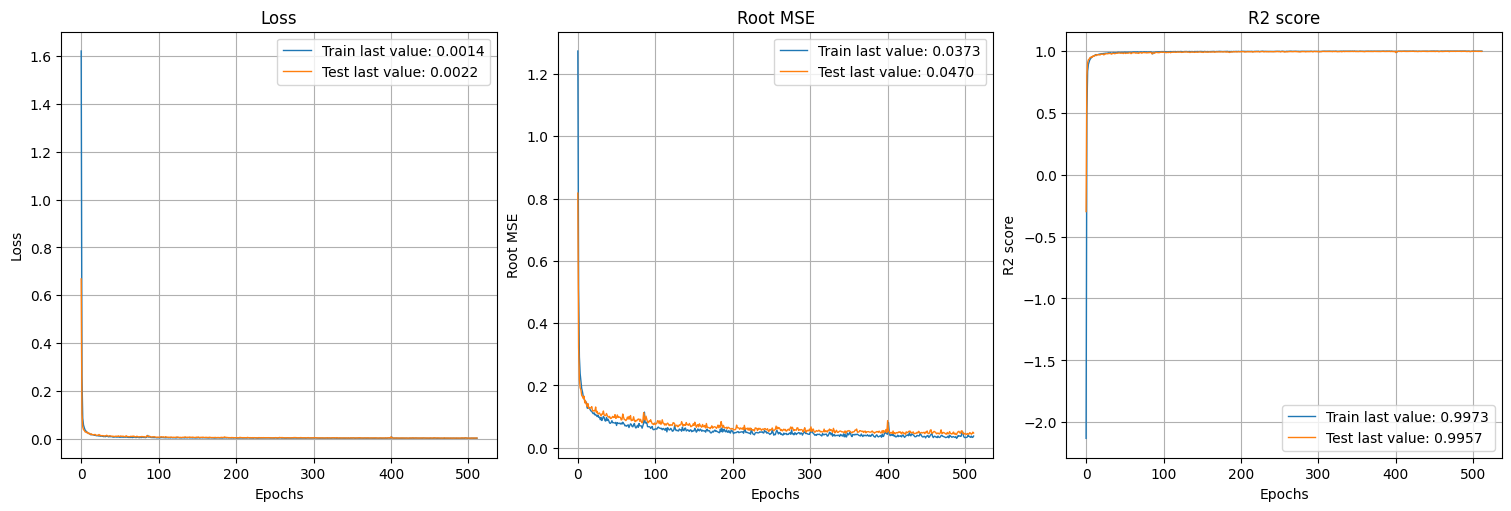

In [12]:
# вывод графиков с изменением метрик
show_history(history)
plot_history(history, path="standard.png")
plt.close()

In [13]:
# предсказание модели на тестовых данных
y_predict = model.predict(X_test)

20/20 [==============================] - 0s 2ms/step


In [14]:
# вывод метрик
print("Тестовая выборка:")
model.evaluate(X_test,y_test)
print("Валидационная выборка:")
model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
model.evaluate(X_train,y_train)
pass

Тестовая выборка:
20/20 [==============================] - 0s 4ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - r2_score: 0.9953
Валидационная выборка:
25/25 [==============================] - 0s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0470 - r2_score: 0.9957
Тренировочная выборка:
79/79 [==============================] - 0s 2ms/step - loss: 7.3638e-04 - root_mean_squared_error: 0.0271 - r2_score: 0.9986


In [15]:
# предсказание модели на полных данных
y_predict_all = model.predict(X)

123/123 [==============================] - 0s 2ms/step


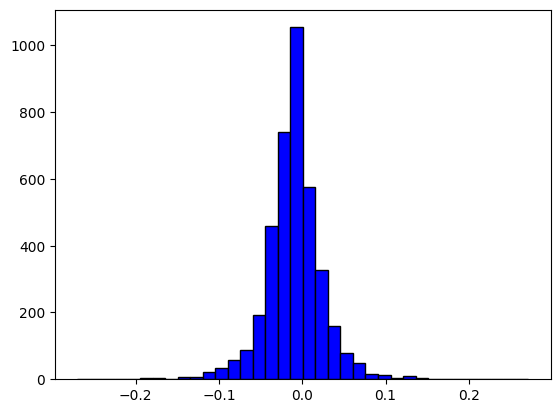

In [16]:
spo  = y_predict_all[:,0]-Y
plt.hist(spo, color = 'blue', edgecolor = 'black',
         bins = int(180/5))
plt.show()

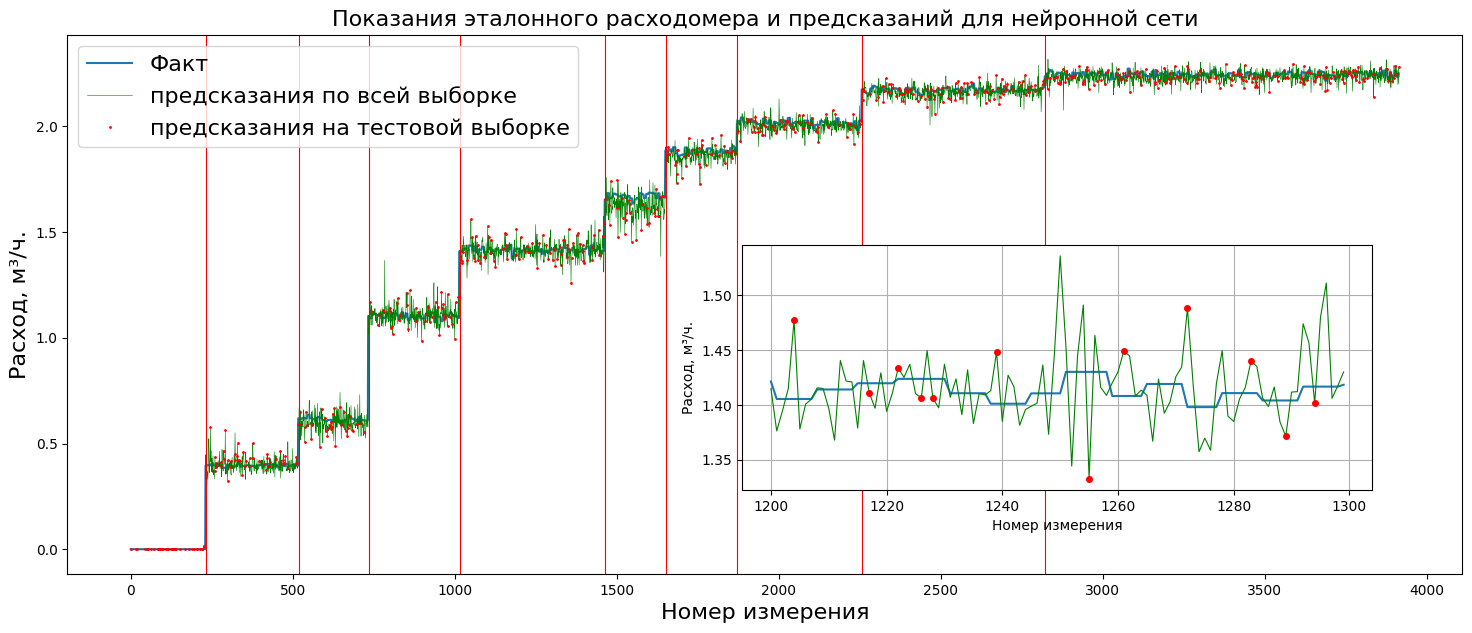

In [17]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="нейронной сети")

In [18]:
# Загружаем лучшую модель
best_model = keras.models.load_model("/content/Checkpoint_path.keras")

In [19]:
# вывод метрик
print("Тестовая выборка:")
best_model.evaluate(X_test,y_test)
print("Валидационная выборка:")
best_model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
best_model.evaluate(X_train,y_train)
pass

Тестовая выборка:
20/20 [==============================] - 0s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466 - r2_score: 0.9958 
Валидационная выборка:
25/25 [==============================] - 0s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422 - r2_score: 0.9965
Тренировочная выборка:
79/79 [==============================] - 0s 2ms/step - loss: 4.5595e-04 - root_mean_squared_error: 0.0214 - r2_score: 0.9991


In [20]:
# предсказание модели на тестовых данных
y_predict = best_model.predict(X_test)

20/20 [==============================] - 0s 2ms/step


In [21]:
# предсказание модели на полных данных
y_predict_all = best_model.predict(X)

123/123 [==============================] - 0s 2ms/step


(array([  1.,   1.,   0.,   0.,   1.,   1.,   0.,   2.,   6.,   7.,  13.,
         14.,  16.,  27.,  44.,  82., 165., 350., 552., 936., 651., 543.,
        258., 126.,  43.,  26.,  13.,  14.,   9.,   3.,   4.,   1.,   2.,
          1.,   2.,   1.]),
 array([-0.24314332, -0.23079723, -0.21845115, -0.20610506, -0.19375898,
        -0.18141289, -0.16906681, -0.15672072, -0.14437464, -0.13202855,
        -0.11968246, -0.10733638, -0.09499029, -0.08264421, -0.07029812,
        -0.05795204, -0.04560595, -0.03325987, -0.02091378, -0.00856769,
         0.00377839,  0.01612448,  0.02847056,  0.04081665,  0.05316273,
         0.06550882,  0.0778549 ,  0.09020099,  0.10254708,  0.11489316,
         0.12723925,  0.13958533,  0.15193142,  0.1642775 ,  0.17662359,
         0.18896968,  0.20131576]),
 <BarContainer object of 36 artists>)

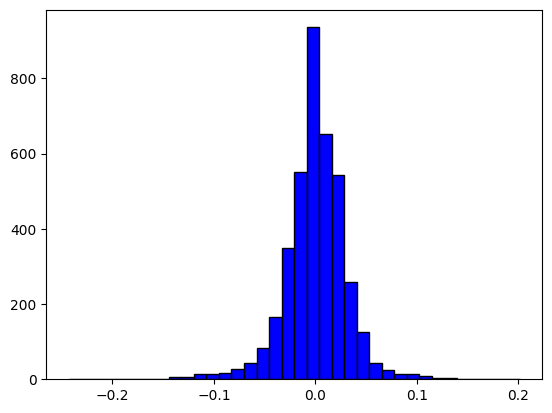

In [22]:
spo  = y_predict_all[:,0]-Y
plt.hist(spo, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

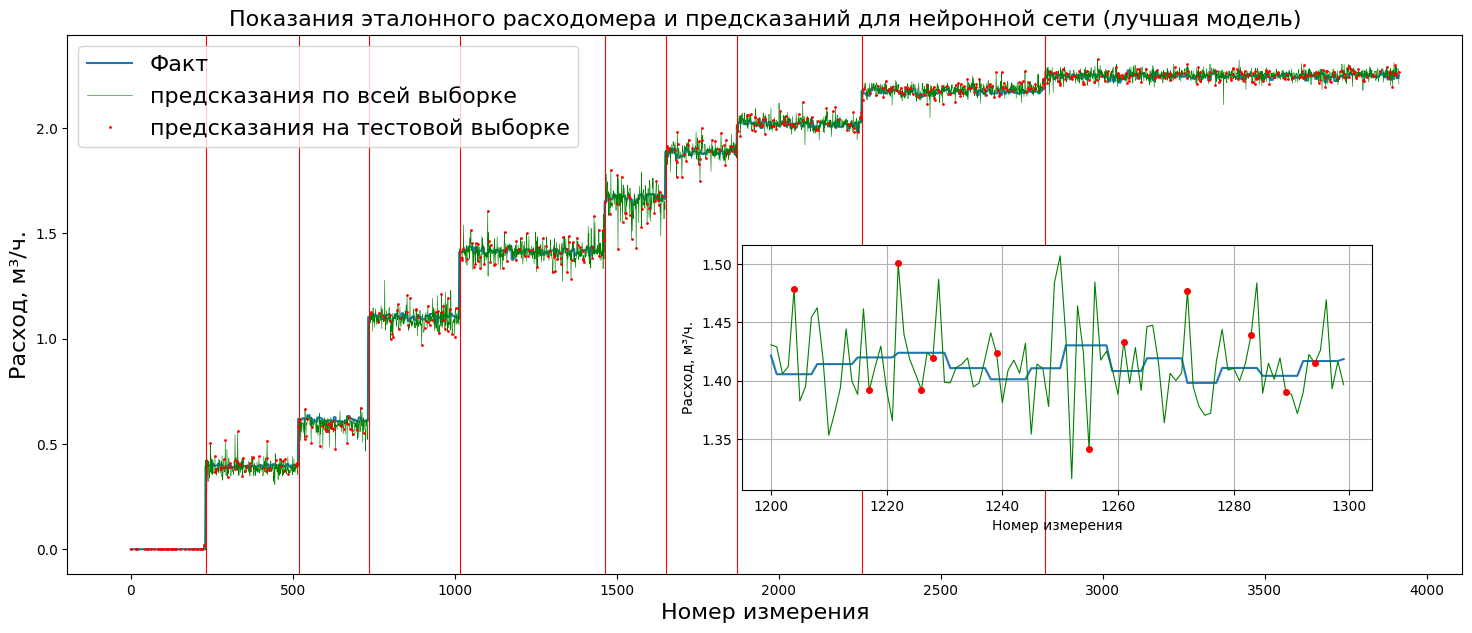

In [23]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="нейронной сети (лучшая модель)")

<h2>Проверим работу модели, приняв за тестовую выборку один из режимов расхода</h2>

In [24]:
# Новое разделение на тестовую, валидационную и обучающую выборки

l_ = len(Y)

_, _, _, _, i_val = my_test_train_split(X, Y, borders, test_size=0.2)

i_test = list(range(borders[3],borders[4]))

i_train = list(range(0,l_))
for x1 in i_test:
  i_train.remove(x1)
for x2 in i_val:
  try:
    i_train.remove(x2)
  except:
    i_ = 0

for x3 in i_test:
  try:
    i_val.remove(x3)
  except:
    i_ = 0

X_train = X[i_train,:]
y_train = Y[i_train]

X_val = X[i_val,:]
y_val = Y[i_val]

X_test = X[i_test,:]
y_test = Y[i_test]

In [25]:
# сброс весов модели
model.load_weights('model.h5')

In [26]:
# сброс лучшей модели
try:
    os.remove("/content/Checkpoint_path.keras")
except OSError:
    print("removing is failed")

In [27]:
# Обучение модели
history = model.fit(
    X_train, y_train, epochs=512, batch_size=64,
    callbacks=callback_list, validation_data=(X_val, y_val)
    )

Epoch 1/512
44/44 [==============================] - 0s 11ms/step - loss: 0.6937 - root_mean_squared_error: 0.8329 - r2_score: -0.2007 - val_loss: 0.1791 - val_root_mean_squared_error: 0.4231 - val_r2_score: 0.6893
Epoch 2/512
44/44 [==============================] - 0s 10ms/step - loss: 0.1444 - root_mean_squared_error: 0.3800 - r2_score: 0.7500 - val_loss: 0.1118 - val_root_mean_squared_error: 0.3343 - val_r2_score: 0.8061
Epoch 3/512
44/44 [==============================] - 0s 10ms/step - loss: 0.0822 - root_mean_squared_error: 0.2868 - r2_score: 0.8577 - val_loss: 0.0466 - val_root_mean_squared_error: 0.2158 - val_r2_score: 0.9192
Epoch 4/512
44/44 [==============================] - 0s 10ms/step - loss: 0.0384 - root_mean_squared_error: 0.1959 - r2_score: 0.9336 - val_loss: 0.0345 - val_root_mean_squared_error: 0.1857 - val_r2_score: 0.9402
Epoch 5/512
44/44 [==============================] - 0s 10ms/step - loss: 0.0273 - root_mean_squared_error: 0.1653 - r2_score: 0.9527 - val_los

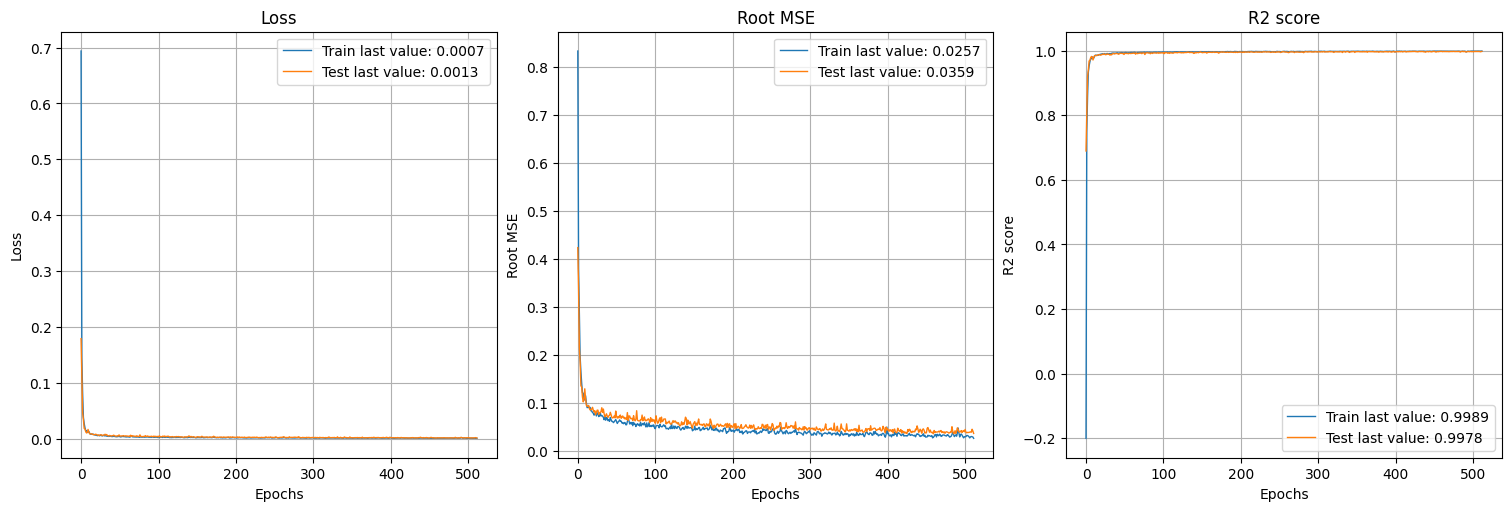

In [28]:
# вывод графиков с изменением метрик
show_history(history)
plot_history(history, path="standard.png")
plt.close()

In [29]:
# предсказание модели на тестовых данных
y_predict = model.predict(X_test)

15/15 [==============================] - 0s 2ms/step


In [30]:
# вывод метрик
print("Тестовая выборка:")
model.evaluate(X_test,y_test)
print("Валидационная выборка:")
model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
model.evaluate(X_train,y_train)
pass

Тестовая выборка:
15/15 [==============================] - 0s 3ms/step - loss: 0.0260 - root_mean_squared_error: 0.1614 - r2_score: -99.2983
Валидационная выборка:
22/22 [==============================] - 0s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359 - r2_score: 0.9978 
Тренировочная выборка:
87/87 [==============================] - 0s 3ms/step - loss: 2.9154e-04 - root_mean_squared_error: 0.0171 - r2_score: 0.9995


In [31]:
# предсказание модели на полных данных
y_predict_all = model.predict(X)
print_scores(Y, y_predict_all, False)

123/123 [==============================] - 0s 2ms/step
Ошибка на тренировочных данных
MSE: 0.00342
RMSE: 0.05849
R2 : 0.99338


(array([1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        5.000e+00, 1.000e+01, 3.300e+01, 1.410e+02, 5.820e+02, 1.517e+03,
        8.460e+02, 2.520e+02, 9.200e+01, 5.400e+01, 4.400e+01, 4.300e+01,
        3.200e+01, 5.400e+01, 3.400e+01, 4.000e+01, 3.500e+01, 2.700e+01,
        1.500e+01, 1.600e+01, 1.100e+01, 6.000e+00, 6.000e+00, 7.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([-0.19883251, -0.18150556, -0.16417862, -0.14685167, -0.12952472,
        -0.11219777, -0.09487083, -0.07754388, -0.06021693, -0.04288998,
        -0.02556303, -0.00823609,  0.00909086,  0.02641781,  0.04374476,
         0.0610717 ,  0.07839865,  0.0957256 ,  0.11305255,  0.13037949,
         0.14770644,  0.16503339,  0.18236034,  0.19968729,  0.21701423,
         0.23434118,  0.25166813,  0.26899508,  0.28632202,  0.30364897,
         0.32097592,  0.33830287,  0.35562981,  0.37295676,  0.39028371,
         0.40761066,  0.42493761]),
 <BarCo

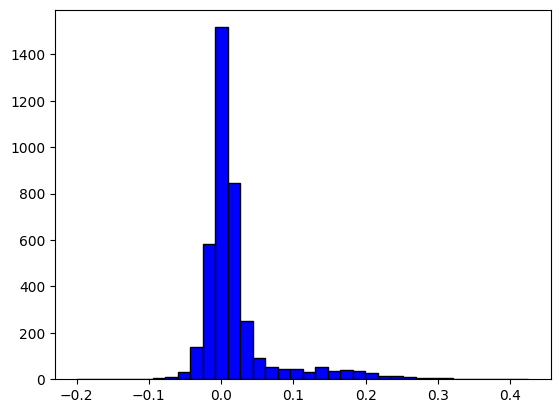

In [32]:
spo  = y_predict_all[:,0]-Y
plt.hist(spo, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

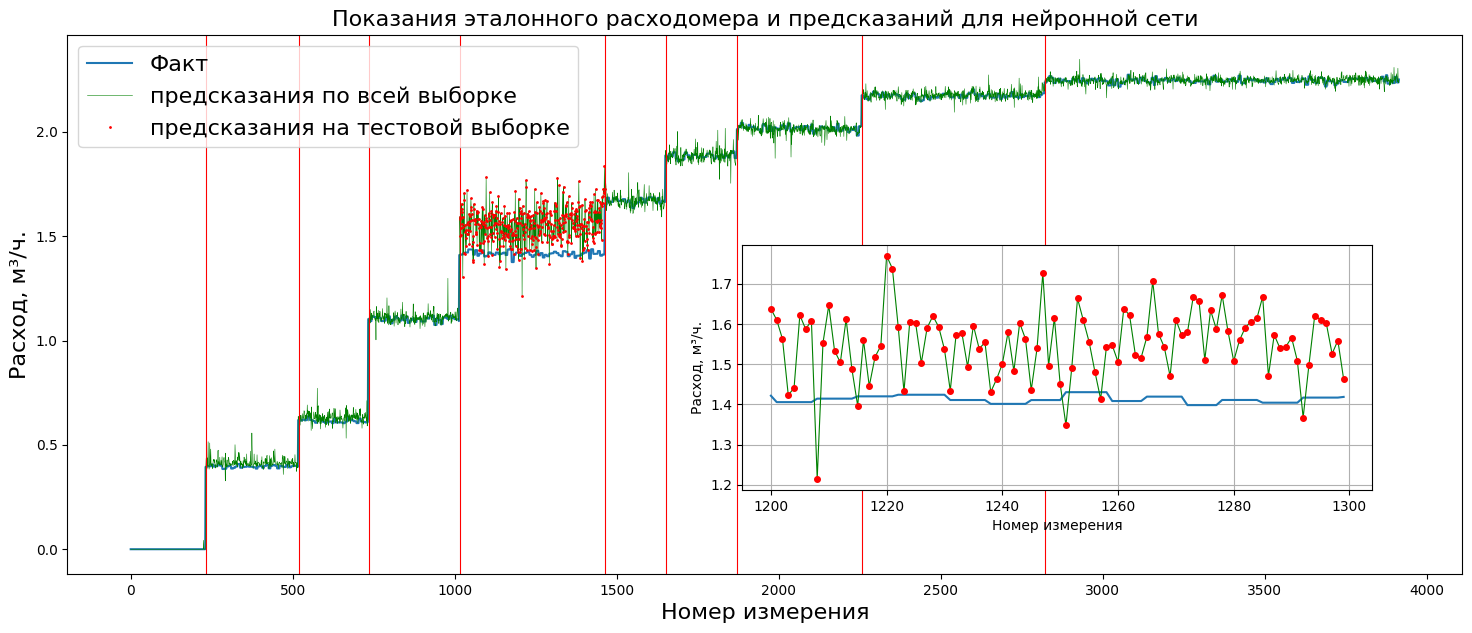

In [33]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="нейронной сети")

In [34]:
try:
  best_model = keras.models.load_model("/content/Checkpoint_path.keras")
except:
  pass

In [35]:
# вывод метрик
try:
  print("Тестовая выборка:")
  best_model.evaluate(X_test,y_test)
  print("Валидационная выборка:")
  best_model.evaluate(X_val,y_val)
  print("Тренировочная выборка:")
  best_model.evaluate(X_train,y_train)
except:
  pass

Тестовая выборка:
15/15 [==============================] - 0s 3ms/step - loss: 0.0130 - root_mean_squared_error: 0.1140 - r2_score: -49.0436
Валидационная выборка:
22/22 [==============================] - 0s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0353 - r2_score: 0.9978 
Тренировочная выборка:
87/87 [==============================] - 0s 2ms/step - loss: 3.2731e-04 - root_mean_squared_error: 0.0181 - r2_score: 0.9994


In [36]:
# предсказание модели на тестовых данных
try:
  y_predict = best_model.predict(X_test)
except:
  pass

15/15 [==============================] - 0s 2ms/step


In [37]:
# предсказание модели на полных данных
try:
  y_predict_all = best_model.predict(X)
except:
  pass

123/123 [==============================] - 0s 2ms/step


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        4.000e+00, 5.000e+00, 9.000e+00, 1.500e+01, 3.000e+01, 7.600e+01,
        3.090e+02, 8.290e+02, 1.461e+03, 6.470e+02, 1.810e+02, 7.600e+01,
        5.100e+01, 3.500e+01, 4.800e+01, 4.200e+01, 2.600e+01, 1.900e+01,
        7.000e+00, 1.200e+01, 9.000e+00, 5.000e+00, 4.000e+00, 4.000e+00,
        5.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-0.25302839, -0.23529557, -0.21756275, -0.19982994, -0.18209712,
        -0.1643643 , -0.14663148, -0.12889866, -0.11116584, -0.09343302,
        -0.0757002 , -0.05796738, -0.04023457, -0.02250175, -0.00476893,
         0.01296389,  0.03069671,  0.04842953,  0.06616235,  0.08389517,
         0.10162799,  0.1193608 ,  0.13709362,  0.15482644,  0.17255926,
         0.19029208,  0.2080249 ,  0.22575772,  0.24349054,  0.26122336,
         0.27895617,  0.29668899,  0.31442181,  0.33215463,  0.34988745,
         0.36762027,  0.38535309]),
 <BarCo

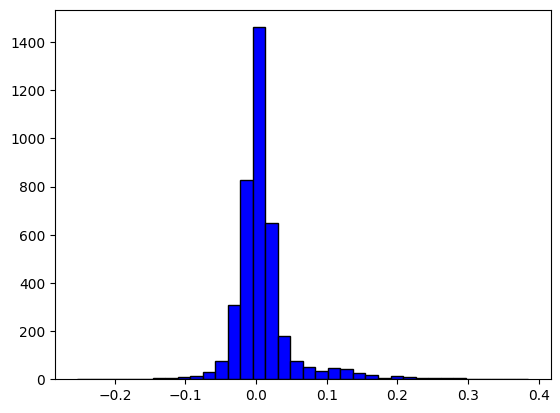

In [38]:
spo  = y_predict_all[:,0]-Y
plt.hist(spo, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

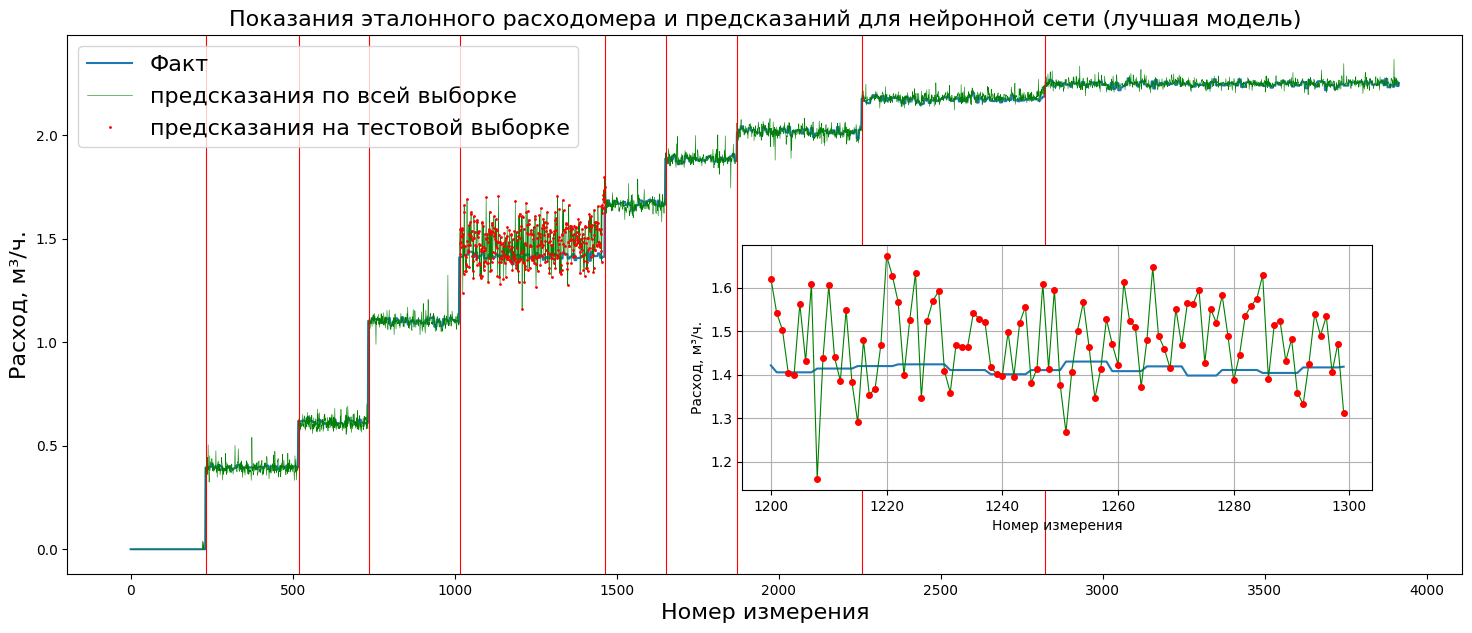

In [39]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="нейронной сети (лучшая модель)")

<h2>Построим нейронную сеть для данных, сглаженных фильтром Савцикого-Голея</h2>

In [80]:
from scipy.signal import savgol_filter
sig_up_sg = sig_up.apply(lambda x: savgol_filter(x,30,4), axis=0) # сглаженные сигналы 1-го пьезоэлектрического датчика
sig_dw_sg = sig_dw.apply(lambda x: savgol_filter(x,30,4), axis=0) # сглаженные сигналы 2-го пьезоэлектрического датчика

In [81]:
X = np.hstack([sig_up, sig_dw])
X.shape

scaler_up = preprocessing.StandardScaler()
X = scaler_up.fit_transform(X)

In [82]:
# Разделение на выборки

Y = np.array(Y_['Et'])
input_dim = X.shape[1]

X_train, y_train, i_train, X_val, y_val, i_val, X_test, y_test, i_test =  my_test_val_train_split(X, Y, borders)

In [83]:
# изменение формата данных
X_train = tf.convert_to_tensor(X_train, np.float32)
X_test = tf.convert_to_tensor(X_test, np.float32)
X_val = tf.convert_to_tensor(X_val, np.float32)
y_train = tf.convert_to_tensor(y_train, np.float32)
y_val = tf.convert_to_tensor(y_val, np.float32)
y_test = tf.convert_to_tensor(y_test, np.float32)

In [84]:
# сброс весов модели
model.load_weights('model.h5')

# сброс лучшей модели
try:
    os.remove("/content/Checkpoint_path.keras")
except OSError:
    print("removing is failed")

removing is failed


In [85]:
# Обучение модели
history = model.fit(
    X_train, y_train, epochs=512, batch_size=64,
    callbacks=callback_list, validation_data=(X_val, y_val)
    )

Epoch 1/512
40/40 [==============================] - 2s 17ms/step - loss: 1.5513 - root_mean_squared_error: 1.2455 - r2_score: -1.9951 - val_loss: 0.3755 - val_root_mean_squared_error: 0.6128 - val_r2_score: 0.2729
Epoch 2/512
40/40 [==============================] - 0s 12ms/step - loss: 0.2016 - root_mean_squared_error: 0.4490 - r2_score: 0.6108 - val_loss: 0.0895 - val_root_mean_squared_error: 0.2992 - val_r2_score: 0.8266
Epoch 3/512
40/40 [==============================] - 0s 10ms/step - loss: 0.0862 - root_mean_squared_error: 0.2937 - r2_score: 0.8335 - val_loss: 0.0522 - val_root_mean_squared_error: 0.2284 - val_r2_score: 0.8989
Epoch 4/512
40/40 [==============================] - 0s 11ms/step - loss: 0.0606 - root_mean_squared_error: 0.2463 - r2_score: 0.8829 - val_loss: 0.0395 - val_root_mean_squared_error: 0.1987 - val_r2_score: 0.9235
Epoch 5/512
40/40 [==============================] - 0s 12ms/step - loss: 0.0495 - root_mean_squared_error: 0.2226 - r2_score: 0.9044 - val_los

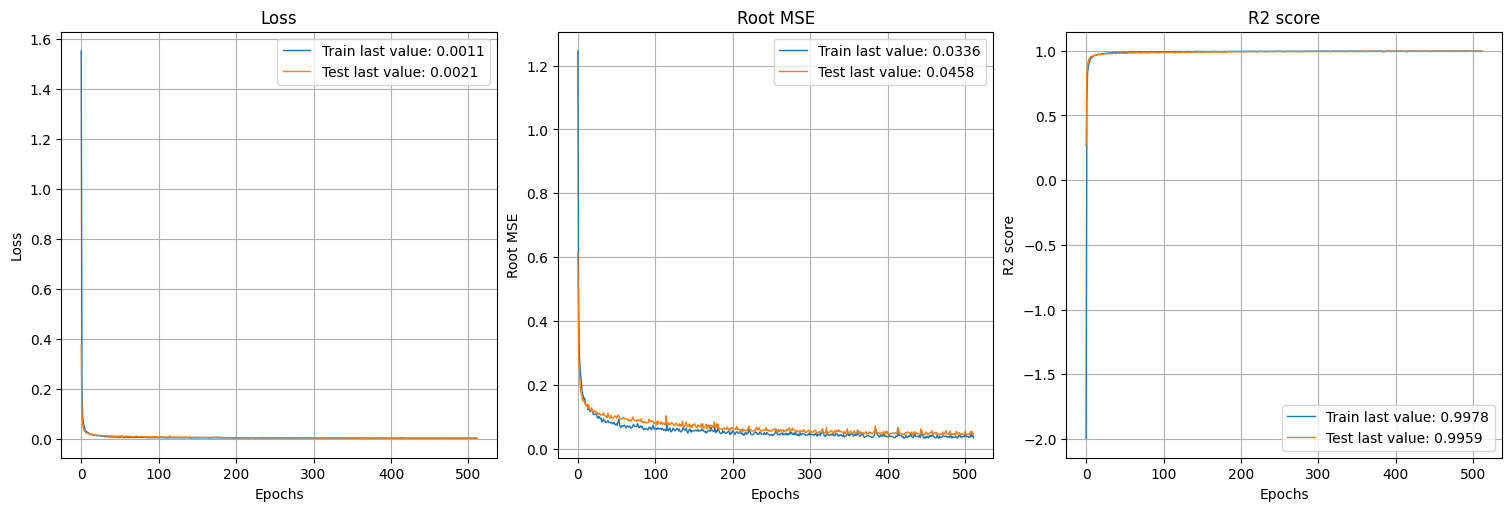

In [86]:
# вывод графиков с изменением метрик
show_history(history)
plot_history(history, path="standard.png")
plt.close()

In [87]:
# предсказание модели на тестовых данных
y_predict = model.predict(X_test)

20/20 [==============================] - 0s 2ms/step


In [88]:
# вывод метрик
print("Тестовая выборка:")
model.evaluate(X_test,y_test)
print("Валидационная выборка:")
model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
model.evaluate(X_train,y_train)
pass

Тестовая выборка:
20/20 [==============================] - 0s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475 - r2_score: 0.9956
Валидационная выборка:
25/25 [==============================] - 0s 4ms/step - loss: 0.0021 - root_mean_squared_error: 0.0458 - r2_score: 0.9959
Тренировочная выборка:
79/79 [==============================] - 0s 2ms/step - loss: 8.1917e-04 - root_mean_squared_error: 0.0286 - r2_score: 0.9984


In [89]:
# предсказание модели на полных данных
#X = X.reshape(X.shape[0], 2, 512,1)
y_predict_all = model.predict(X)
print_scores(Y, y_predict_all)

123/123 [==============================] - 0s 2ms/step
Ошибка на полных данных
MSE: 0.00130
RMSE: 0.03609
R2 : 0.99748


(array([  1.,   0.,   0.,   1.,   2.,   2.,   3.,   6.,   5.,   7.,  17.,
         26.,  58.,  87., 159., 271., 417., 605., 871., 596., 402., 183.,
         89.,  51.,  24.,  13.,   7.,   6.,   1.,   1.,   2.,   1.,   0.,
          0.,   0.,   1.]),
 array([-0.25316882, -0.23940201, -0.2256352 , -0.21186839, -0.19810157,
        -0.18433476, -0.17056795, -0.15680114, -0.14303433, -0.12926751,
        -0.1155007 , -0.10173389, -0.08796708, -0.07420027, -0.06043345,
        -0.04666664, -0.03289983, -0.01913302, -0.00536621,  0.00840061,
         0.02216742,  0.03593423,  0.04970104,  0.06346785,  0.07723467,
         0.09100148,  0.10476829,  0.1185351 ,  0.13230191,  0.14606873,
         0.15983554,  0.17360235,  0.18736916,  0.20113597,  0.21490279,
         0.2286696 ,  0.24243641]),
 <BarContainer object of 36 artists>)

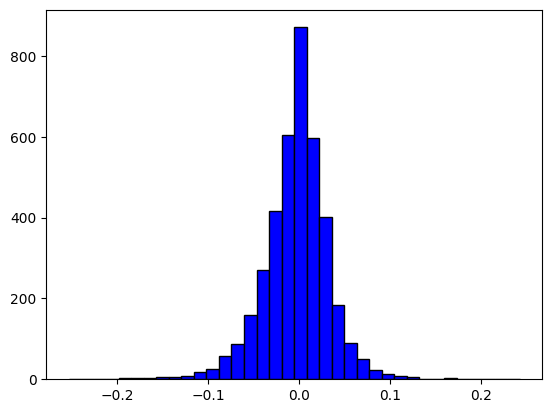

In [90]:
spo  = y_predict_all[:,0]-Y
plt.hist(spo, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

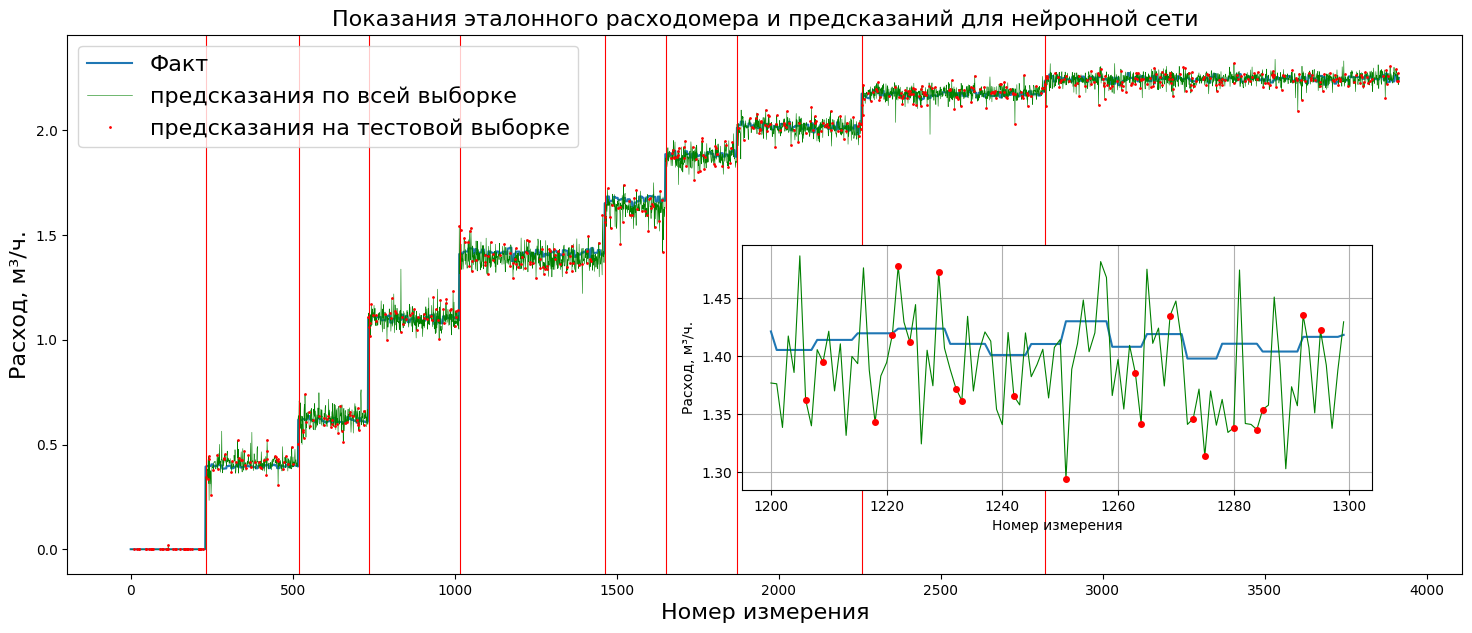

In [91]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="нейронной сети")

In [92]:
# Загружаем лучшую модель
best_model = keras.models.load_model("/content/Checkpoint_path.keras")

In [93]:
# вывод метрик
print("Тестовая выборка:")
best_model.evaluate(X_test,y_test)
print("Валидационная выборка:")
best_model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
best_model.evaluate(X_train,y_train)
pass

Тестовая выборка:
20/20 [==============================] - 0s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457 - r2_score: 0.9959 
Валидационная выборка:
25/25 [==============================] - 0s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417 - r2_score: 0.9966
Тренировочная выборка:
79/79 [==============================] - 0s 3ms/step - loss: 4.7679e-04 - root_mean_squared_error: 0.0218 - r2_score: 0.9991


In [94]:
# предсказание модели на тестовых данных
y_predict = best_model.predict(X_test)

20/20 [==============================] - 0s 2ms/step


In [95]:
# предсказание модели на полных данных
y_predict_all = best_model.predict(X)

123/123 [==============================] - 0s 3ms/step


(array([  1.,   0.,   0.,   0.,   0.,   1.,   1.,   2.,   0.,   1.,   4.,
         12.,   6.,  13.,  15.,  30.,  63., 126., 268., 482., 771., 950.,
        555., 296., 151.,  65.,  50.,  17.,  14.,   9.,   7.,   2.,   0.,
          0.,   1.,   2.]),
 array([-2.74027348e-01, -2.60989808e-01, -2.47952269e-01, -2.34914730e-01,
        -2.21877191e-01, -2.08839652e-01, -1.95802112e-01, -1.82764573e-01,
        -1.69727034e-01, -1.56689495e-01, -1.43651956e-01, -1.30614416e-01,
        -1.17576877e-01, -1.04539338e-01, -9.15017989e-02, -7.84642597e-02,
        -6.54267205e-02, -5.23891813e-02, -3.93516421e-02, -2.63141029e-02,
        -1.32765638e-02, -2.39024562e-04,  1.27985146e-02,  2.58360538e-02,
         3.88735930e-02,  5.19111322e-02,  6.49486714e-02,  7.79862106e-02,
         9.10237498e-02,  1.04061289e-01,  1.17098828e-01,  1.30136367e-01,
         1.43173907e-01,  1.56211446e-01,  1.69248985e-01,  1.82286524e-01,
         1.95324063e-01]),
 <BarContainer object of 36 artists>)

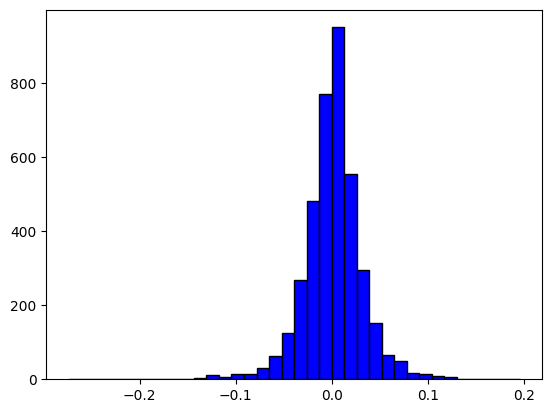

In [96]:
spo  = y_predict_all[:,0]-Y
plt.hist(spo, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

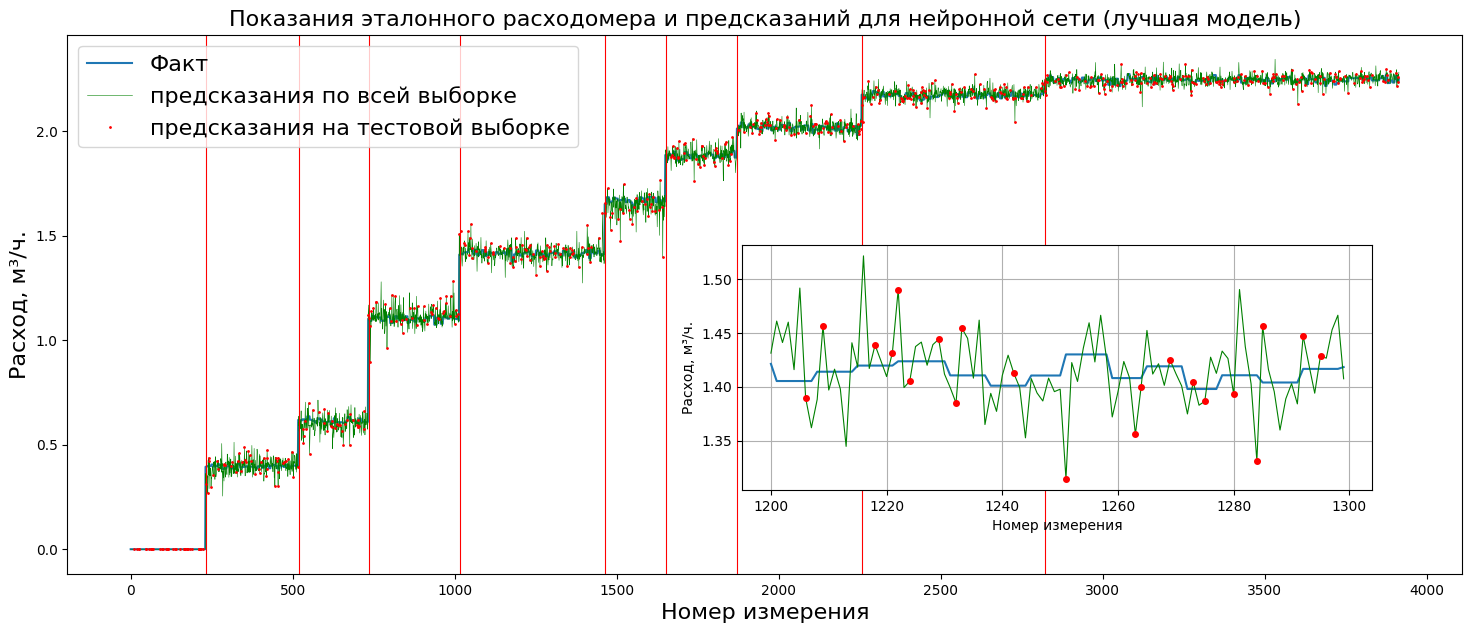

In [97]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="нейронной сети (лучшая модель)")

<h2>Проверим работу модели, приняв за тестовую выборку один из режимов расхода</h2>

In [98]:
# Новое разделение на тестовую, валидационную и обучающую выборки

l_ = len(Y)

_, _, _, _, i_val = my_test_train_split(X, Y, borders, test_size=0.2)

i_test = list(range(borders[3],borders[4]))

i_train = list(range(0,l_))
for x1 in i_test:
  i_train.remove(x1)
for x2 in i_val:
  try:
    i_train.remove(x2)
  except:
    i_ = 0

for x3 in i_test:
  try:
    i_val.remove(x3)
  except:
    i_ = 0

X_train = X[i_train,:]
y_train = Y[i_train]

X_val = X[i_val,:]
y_val = Y[i_val]

X_test = X[i_test,:]
y_test = Y[i_test]


In [99]:
# сброс весов модели
model.load_weights('model.h5')

In [100]:
# сброс лучшей модели
try:
    os.remove("/content/Checkpoint_path.keras")
except OSError:
    print("removing is failed")

In [101]:
# Обучение модели
history = model.fit(
    X_train, y_train, epochs=512, batch_size=64,
    callbacks=callback_list, validation_data=(X_val, y_val)
    )

Epoch 1/512
44/44 [==============================] - 1s 13ms/step - loss: 0.8060 - root_mean_squared_error: 0.8978 - r2_score: -0.3944 - val_loss: 0.1660 - val_root_mean_squared_error: 0.4074 - val_r2_score: 0.7115
Epoch 2/512
44/44 [==============================] - 1s 15ms/step - loss: 0.1343 - root_mean_squared_error: 0.3664 - r2_score: 0.7677 - val_loss: 0.0947 - val_root_mean_squared_error: 0.3077 - val_r2_score: 0.8355
Epoch 3/512
44/44 [==============================] - 1s 16ms/step - loss: 0.0604 - root_mean_squared_error: 0.2457 - r2_score: 0.8955 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1730 - val_r2_score: 0.9480
Epoch 4/512
44/44 [==============================] - 1s 17ms/step - loss: 0.0342 - root_mean_squared_error: 0.1849 - r2_score: 0.9408 - val_loss: 0.0267 - val_root_mean_squared_error: 0.1635 - val_r2_score: 0.9535
Epoch 5/512
44/44 [==============================] - 1s 19ms/step - loss: 0.0209 - root_mean_squared_error: 0.1445 - r2_score: 0.9639 - val_los

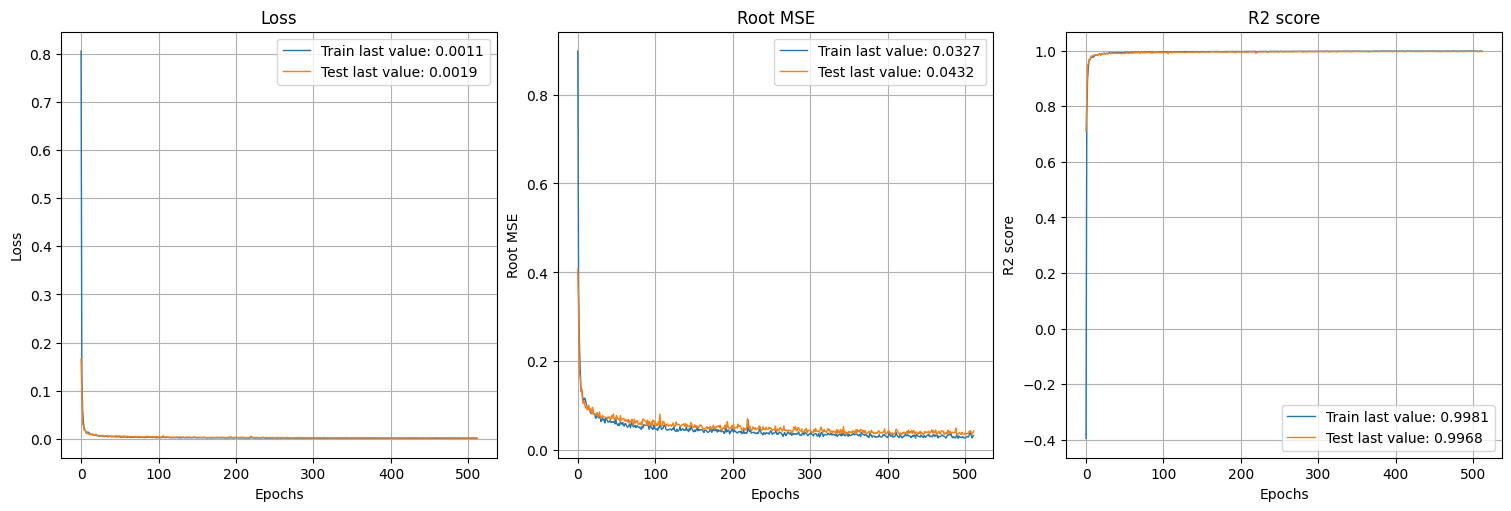

In [102]:
# вывод графиков с изменением метрик
show_history(history)
plot_history(history, path="standard.png")
plt.close()

In [103]:
# предсказание модели на тестовых данных
y_predict = model.predict(X_test)

15/15 [==============================] - 0s 2ms/step


In [104]:
# вывод метрик
print("Тестовая выборка:")
model.evaluate(X_test,y_test)
print("Валидационная выборка:")
model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
model.evaluate(X_train,y_train)
pass

Тестовая выборка:
15/15 [==============================] - 0s 3ms/step - loss: 0.0316 - root_mean_squared_error: 0.1777 - r2_score: -120.6216
Валидационная выборка:
22/22 [==============================] - 0s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0432 - r2_score: 0.9968
Тренировочная выборка:
87/87 [==============================] - 0s 3ms/step - loss: 9.8343e-04 - root_mean_squared_error: 0.0314 - r2_score: 0.9983


In [105]:
# предсказание модели на полных данных
y_predict_all = model.predict(X)
print_scores(Y, y_predict_all, False)

123/123 [==============================] - 0s 2ms/step
Ошибка на тренировочных данных
MSE: 0.00465
RMSE: 0.06818
R2 : 0.99101


(array([  1.,   1.,   2.,   0.,   5.,   2.,  12.,  27.,  87., 400., 957.,
        596., 714., 387., 257., 100.,  48.,  29.,  40.,  34.,  53.,  42.,
         26.,  30.,  28.,  14.,   9.,   4.,   7.,   0.,   1.,   1.,   0.,
          0.,   0.,   1.]),
 array([-0.20530629, -0.18659928, -0.16789227, -0.14918526, -0.13047825,
        -0.11177124, -0.09306423, -0.07435722, -0.05565021, -0.0369432 ,
        -0.01823619,  0.00047082,  0.01917783,  0.03788484,  0.05659186,
         0.07529887,  0.09400588,  0.11271289,  0.1314199 ,  0.15012691,
         0.16883392,  0.18754093,  0.20624794,  0.22495495,  0.24366196,
         0.26236897,  0.28107598,  0.29978299,  0.31849   ,  0.33719701,
         0.35590402,  0.37461103,  0.39331804,  0.41202505,  0.43073206,
         0.44943908,  0.46814609]),
 <BarContainer object of 36 artists>)

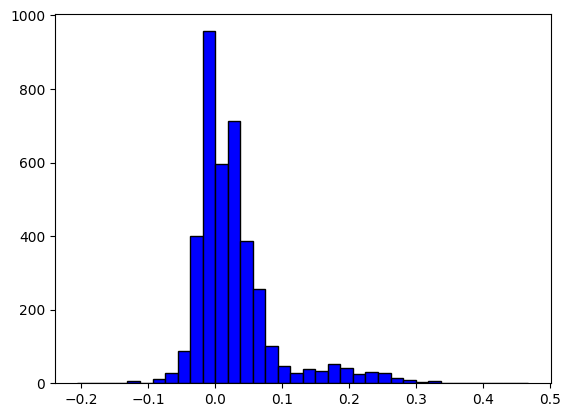

In [106]:
spo  = y_predict_all[:,0]-Y
plt.hist(spo, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

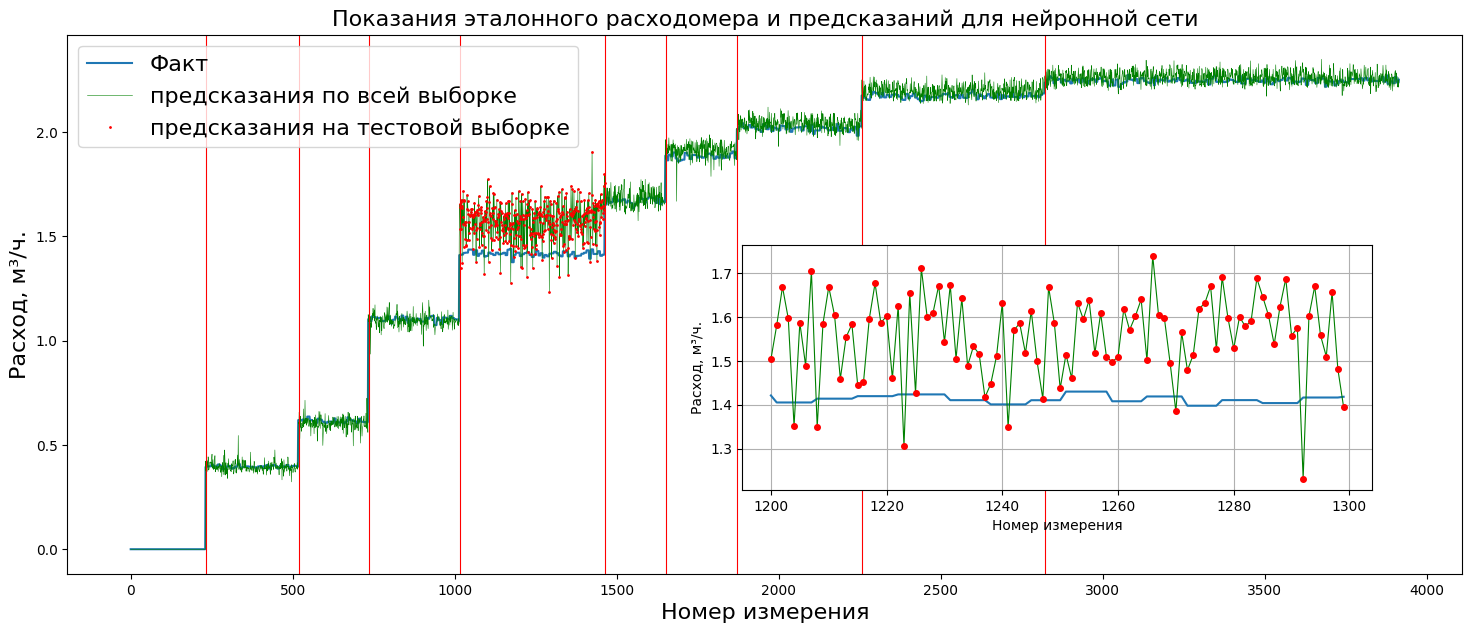

In [107]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="нейронной сети")

In [108]:
best_model = keras.models.load_model("/content/Checkpoint_path.keras")

In [109]:
# вывод метрик
print("Тестовая выборка:")
best_model.evaluate(X_test,y_test)
print("Валидационная выборка:")
best_model.evaluate(X_val,y_val)
print("Тренировочная выборка:")
best_model.evaluate(X_train,y_train)
pass

Тестовая выборка:
15/15 [==============================] - 0s 3ms/step - loss: 0.0159 - root_mean_squared_error: 0.1261 - r2_score: -60.2256
Валидационная выборка:
22/22 [==============================] - 0s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0347 - r2_score: 0.9979
Тренировочная выборка:
87/87 [==============================] - 0s 3ms/step - loss: 3.7906e-04 - root_mean_squared_error: 0.0195 - r2_score: 0.9993


In [110]:
# предсказание модели на тестовых данных
y_predict = best_model.predict(X_test)

15/15 [==============================] - 0s 2ms/step


In [111]:
# предсказание модели на полных данных
y_predict_all = best_model.predict(X)

123/123 [==============================] - 0s 2ms/step


(array([3.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 4.000e+00, 1.300e+01,
        5.100e+01, 1.150e+02, 5.350e+02, 1.744e+03, 8.830e+02, 2.540e+02,
        7.700e+01, 7.000e+01, 3.200e+01, 2.900e+01, 2.400e+01, 1.600e+01,
        2.000e+01, 1.200e+01, 6.000e+00, 8.000e+00, 3.000e+00, 3.000e+00,
        3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-0.22645259, -0.2032878 , -0.180123  , -0.15695821, -0.13379342,
        -0.11062863, -0.08746384, -0.06429904, -0.04113425, -0.01796946,
         0.00519533,  0.02836013,  0.05152492,  0.07468971,  0.0978545 ,
         0.12101929,  0.14418409,  0.16734888,  0.19051367,  0.21367846,
         0.23684325,  0.26000805,  0.28317284,  0.30633763,  0.32950242,
         0.35266722,  0.37583201,  0.3989968 ,  0.42216159,  0.44532638,
         0.46849118,  0.49165597,  0.51482076,  0.53798555,  0.56115035,
         0.58431514,  0.60747993]),
 <BarCo

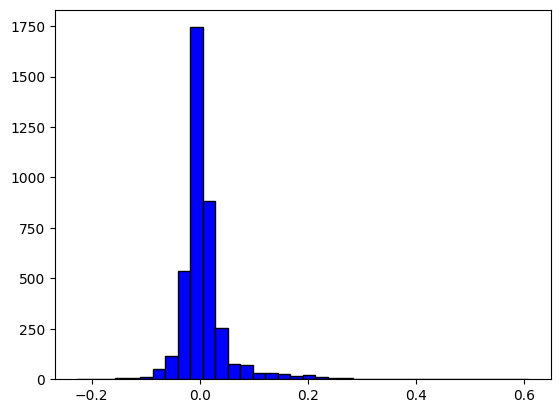

In [112]:
spo  = y_predict_all[:,0]-Y
plt.hist(spo, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

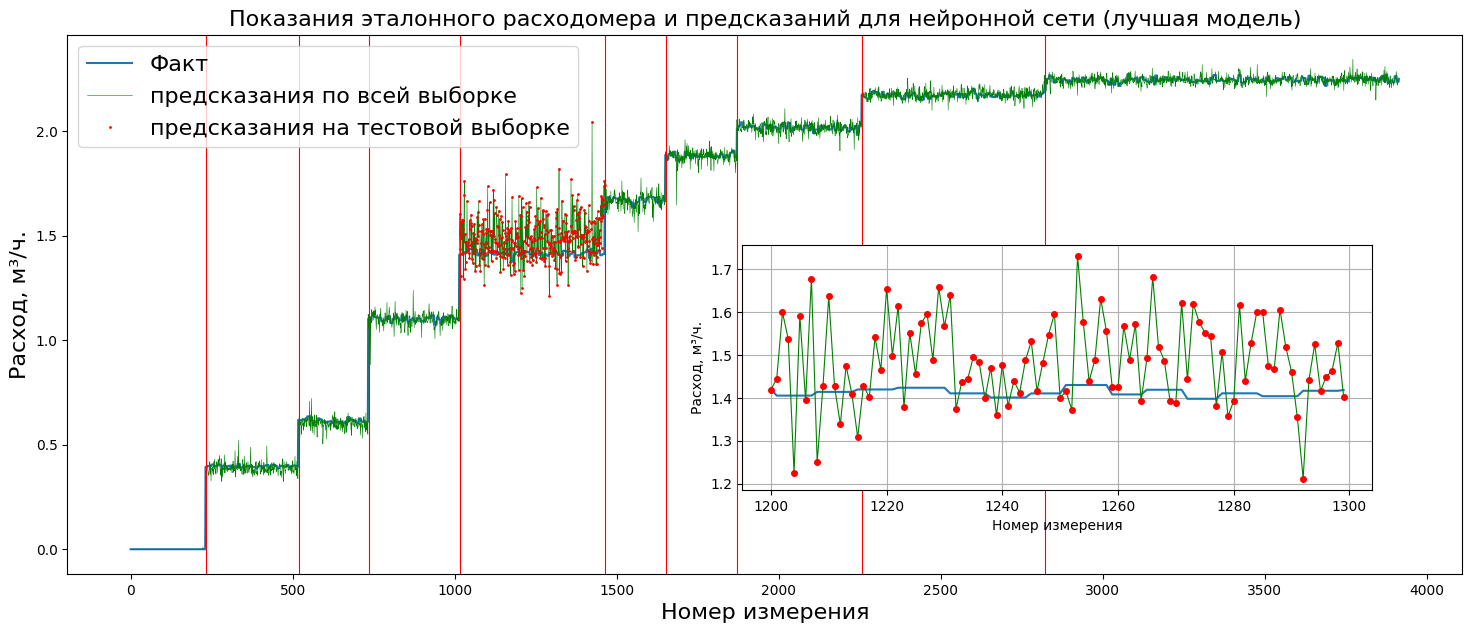

In [113]:
# Вывод графика с фактическими и предсказанными данными
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="нейронной сети (лучшая модель)")

In [114]:
#del[model]